# Explore here

In [ ]:
# Import
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Splitting data
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import silhouette_score

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Save the model
from pickle import dump

# Utils
import warnings
warnings.filterwarnings("ignore")

In [141]:
# Get data
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")

# Configure pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Initial Data Display
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Meaning of the dataset features:

- `MedInc`: Median household income within a block of houses (measured in tens of thousands of dollars)
- `HouseAge`: Median age of a house within a block; a lower number indicates a newer building
- `AveRooms`: Average number of rooms within a block
- `AveBedrms`: Average number of bedrooms within a block
- `Population`: Total number of people residing within a block
- `AveOccup`: Average number of people per household residing within a block (Population / Households)
- `Latitude`: A measure of how far north a house is located; a higher value indicates a higher value
- `Longitude`: A measure of how far west a house is located; A higher value is the further west it is.
- `MedHouseVal`: Median house value for households within a block (measured in hundreds of thousands of dollars)

In [142]:
# For this classification analysis, only the location of the houses and the average income will be taken into account.
df = df.drop(["HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "MedHouseVal"], axis=1)
df.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [143]:
# DataFrame Dimensions
df.shape

(20640, 3)

In [144]:
# Basic Information on Data Types and Non-Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     20640 non-null  float64
 1   Latitude   20640 non-null  float64
 2   Longitude  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


In [145]:
# Search and Removal of Duplicate Data
duplicates = df.duplicated().sum()
duplicates

np.int64(5)

In [146]:
df = df.drop_duplicates()
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

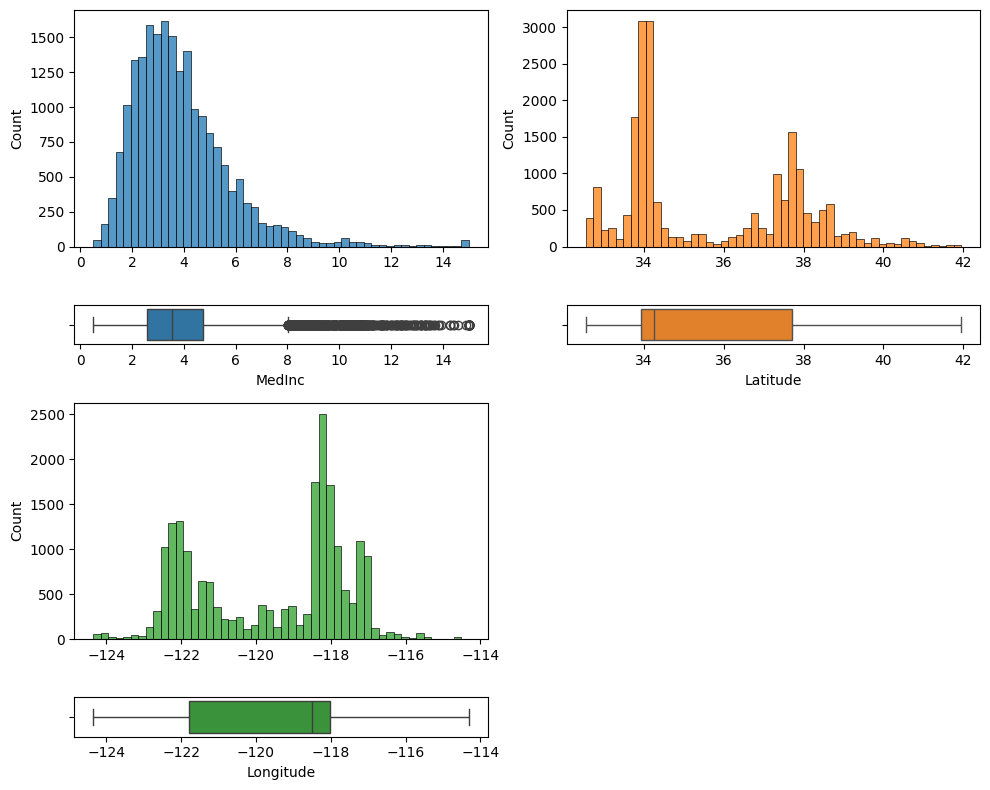

In [147]:
# Analysis of Numerical Variables
fig, axis = plt.subplots(4, 2, figsize = (10, 8), gridspec_kw={'height_ratios': [6, 1, 6, 1]})

# Create a multiple figure with histograms and box plots
sns.histplot(ax = axis[0, 0], data = df, x = "MedInc", bins=50, color="#1f77b4").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = df, x = "MedInc", color="#1f77b4").set(xlabel = "MedInc")

sns.histplot(ax = axis[0, 1], data = df, x = "Latitude", bins=50, color="#ff7f0e").set(xlabel = None)
sns.boxplot(ax = axis[1, 1], data = df, x = "Latitude", color="#ff7f0e").set(xlabel = "Latitude")

sns.histplot(ax = axis[2, 0], data = df, x = "Longitude", bins=50, color="#2ca02c").set(xlabel = None)
sns.boxplot(ax = axis[3, 0], data = df, x = "Longitude", color="#2ca02c").set(xlabel = "Longitude")

# Delete axis
axis[2, 1].axis("off")
axis[3, 1].axis("off")

# Adjust the Layout
plt.tight_layout()

# Display the Plot
plt.show()

In [148]:
# Cleaning outliers

# The distribution of "MedInc" shows outliers
# Since these are average incomes, the data may not be incorrect.

# Interquartile range
med_inc_info = df["MedInc"].describe()
var1_iqr = med_inc_info["75%"] - med_inc_info["25%"]
up_limit = med_inc_info["75%"] + 1.5 * var1_iqr
low_limit = med_inc_info["25%"] - 1.5 * var1_iqr

print(up_limit)

df[df["MedInc"] > 8].shape

# Although the data is not incorrect, in our first analysis we will only take the data less than or equal to 8.
df = df[df["MedInc"] <= 8]
df.shape

# With this removal, we retained more than 96% of the data, so it shouldn't significantly affect our sample.
# If necessary, we'll use a less restrictive threshold to treat these outliers.

8.01185


(19948, 3)

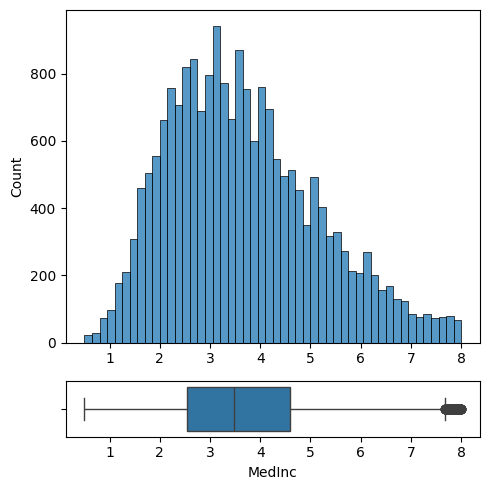

In [149]:
fig, axis = plt.subplots(2, figsize = (5, 5), gridspec_kw={'height_ratios': [6, 1]})
sns.histplot(ax = axis[0], data = df, x = "MedInc", bins=50, color="#1f77b4").set(xlabel = None)
sns.boxplot(ax = axis[1], data = df, x = "MedInc", color="#1f77b4").set(xlabel = "MedInc")
# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

In [150]:
# Splitting data into train and test sets
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 42) # stratify=y for imbalanced classes in the target

In [151]:
# Scaling
# Instantiate the scaler
scaler = StandardScaler().fit(X_train) # or MinMaxScaler
# Transformation and conversion to dataframe of scaled data
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [152]:
# Training
model = KMeans(n_clusters = 6, random_state = 42)
model.fit(X_train_scaled)

KMeans(n_clusters=6, random_state=42)

In [153]:
# Predict in train
clusters_train = model.predict(X_train_scaled)
X_train_scaled['cluster'] = clusters_train

# Predict in test
clusters_test = model.predict(X_test_scaled)
X_test_scaled['cluster'] = clusters_test

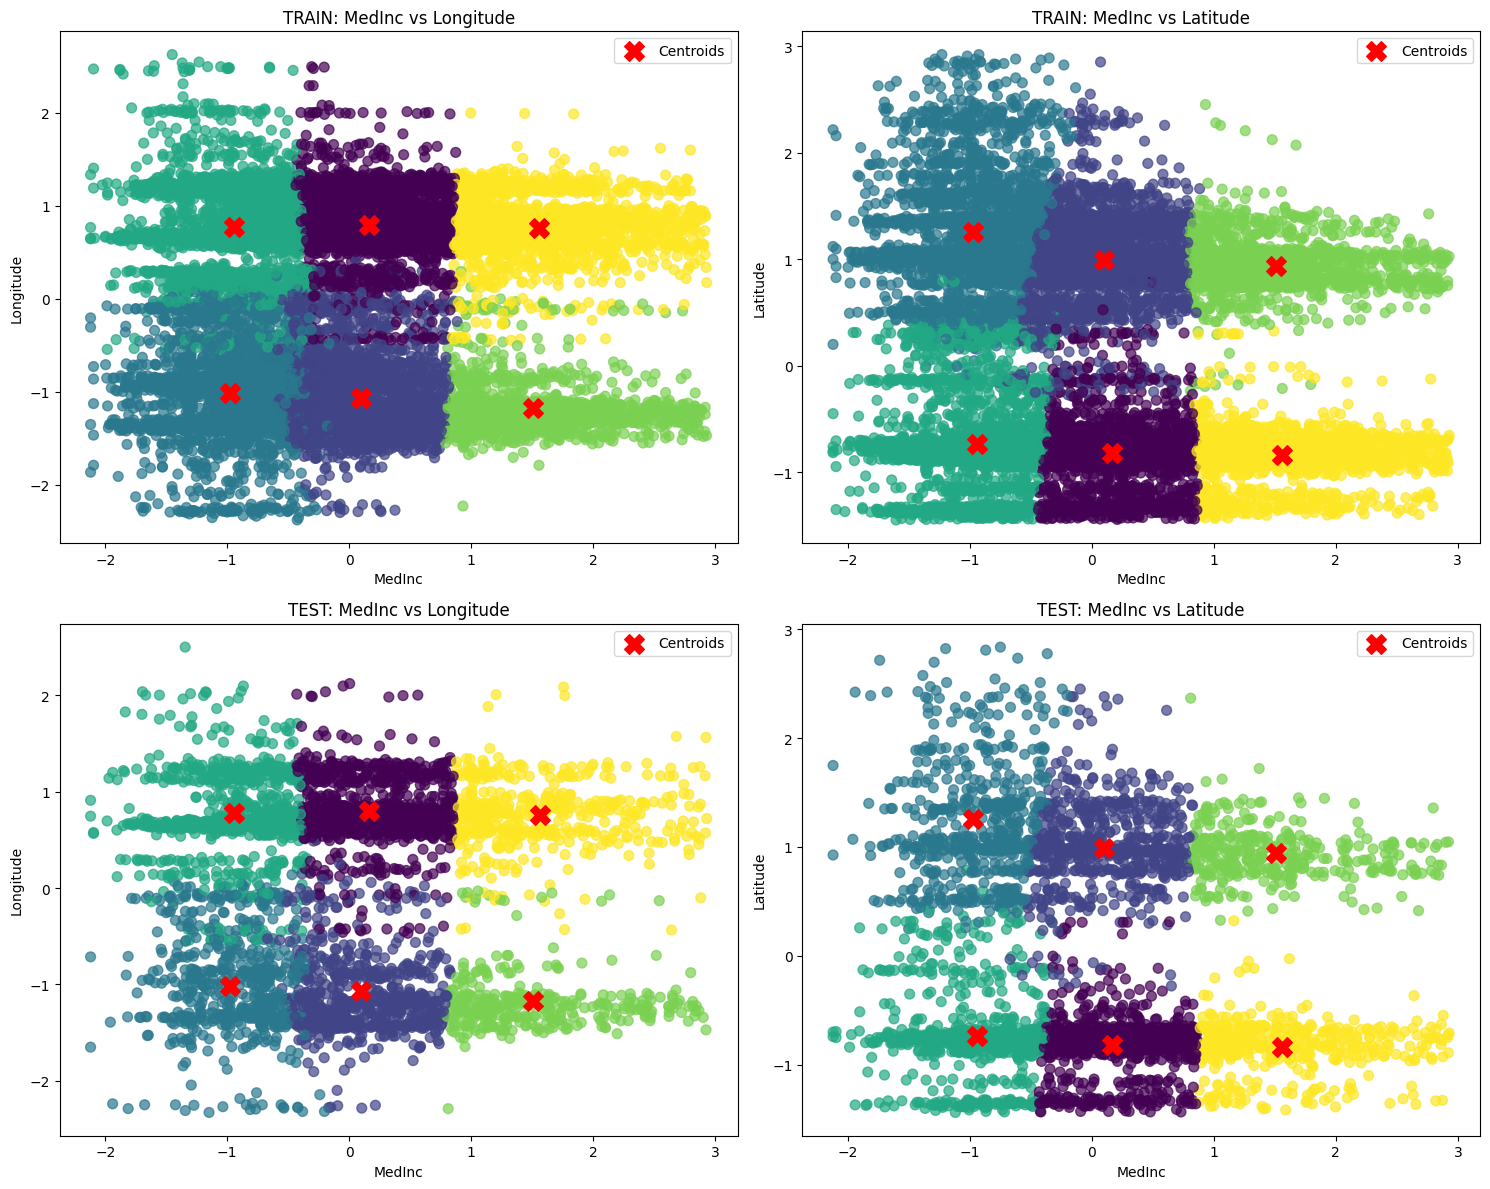

In [154]:
# Get cluster centers
centroids = model.cluster_centers_

fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2 filas, 2 columnas

# TRAIN graphics
# Train: Feature 0 vs Feature 2
scatter1 = axes[0, 0].scatter(
    X_train_scaled.iloc[:, 0],
    X_train_scaled.iloc[:, 2],
    c=clusters_train,
    s=50,
    cmap='viridis',
    alpha=0.7
)
axes[0, 0].scatter(
    centroids[:, 0],
    centroids[:, 2],
    c='red',
    s=200,
    marker='X',
    label='Centroids'
)
axes[0, 0].set_title(f"TRAIN: {X_train_scaled.columns[0]} vs {X_train_scaled.columns[2]}")
axes[0, 0].set_xlabel(X_train_scaled.columns[0])
axes[0, 0].set_ylabel(X_train_scaled.columns[2])
axes[0, 0].legend()

# Train: Feature 0 vs Feature 1
scatter2 = axes[0, 1].scatter(
    X_train_scaled.iloc[:, 0],
    X_train_scaled.iloc[:, 1],
    c=clusters_train,
    s=50,
    cmap='viridis',
    alpha=0.7
)
axes[0, 1].scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='red',
    s=200,
    marker='X',
    label='Centroids'
)
axes[0, 1].set_title(f"TRAIN: {X_train_scaled.columns[0]} vs {X_train_scaled.columns[1]}")
axes[0, 1].set_xlabel(X_train_scaled.columns[0])
axes[0, 1].set_ylabel(X_train_scaled.columns[1])
axes[0, 1].legend()

# TEST Graphics
# Test: Feature 0 vs Feature 2
scatter3 = axes[1, 0].scatter(
    X_test_scaled.iloc[:, 0],
    X_test_scaled.iloc[:, 2],
    c=clusters_test,
    s=50,
    cmap='viridis',
    alpha=0.7
)
axes[1, 0].scatter(
    centroids[:, 0],
    centroids[:, 2],
    c='red',
    s=200,
    marker='X',
    label='Centroids'
)
axes[1, 0].set_title(f"TEST: {X_test_scaled.columns[0]} vs {X_test_scaled.columns[2]}")
axes[1, 0].set_xlabel(X_test_scaled.columns[0])
axes[1, 0].set_ylabel(X_test_scaled.columns[2])
axes[1, 0].legend()

# Test: Feature 0 vs Feature 1
scatter4 = axes[1, 1].scatter(
    X_test_scaled.iloc[:, 0],
    X_test_scaled.iloc[:, 1],
    c=clusters_test,
    s=50,
    cmap='viridis',
    alpha=0.7
)
axes[1, 1].scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='red',
    s=200,
    marker='X',
    label='Centroids'
)
axes[1, 1].set_title(f"TEST: {X_test_scaled.columns[0]} vs {X_test_scaled.columns[1]}")
axes[1, 1].set_xlabel(X_test_scaled.columns[0])
axes[1, 1].set_ylabel(X_test_scaled.columns[1])
axes[1, 1].legend()

# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

In [ ]:
# 3D graphic for train
fig_train = px.scatter_3d(
    X_train_scaled,
    x=X_train_scaled.columns[0],
    y=X_train_scaled.columns[1],
    z=X_train_scaled.columns[2],
    color='cluster',
    title="TRAIN: Clusters"
)
fig_train.write_html("../figures/clustering_3d_TRAIN.html")

# 3D graphic for test
fig_test = px.scatter_3d(
    X_test_scaled,
    x=X_test_scaled.columns[0],
    y=X_test_scaled.columns[1],
    z=X_test_scaled.columns[2],
    color='cluster',
    title="TEST: Clusters"
)
fig_test.write_html("../figures/clustering_3d_TEST.html")

# TO SEE THE FIGURES IN 3D, IT IS RECOMMENDED TO DOWNLOAD THE HTML FOR THE ROUTE ../figures/ AND OPEN THEM IN THE BROWSER
# THEY REPRESENT THE DIVISION MADE BY THE ALGORITHM OF THE 6 CLUSTERS REQUESTED IN TRAIN AND TEST

k = 2, Inertia = 59993.485668589215, Silhouette Index = 0.35178922202824375
k = 3, Inertia = 33022.500021488, Silhouette Index = 0.5153168598638722
k = 4, Inertia = 16519.42675355304, Silhouette Index = 0.6089592418599368
k = 5, Inertia = 10350.03004651051, Silhouette Index = 0.6607339710405735
k = 6, Inertia = 7345.947510727368, Silhouette Index = 0.6343867976207723
k = 7, Inertia = 6549.917598743702, Silhouette Index = 0.5968750573740489
k = 8, Inertia = 6165.359370260928, Silhouette Index = 0.563298597845932
k = 9, Inertia = 5806.82936152942, Silhouette Index = 0.5034746279017681
k = 10, Inertia = 5345.65558547216, Silhouette Index = 0.47819638406400233


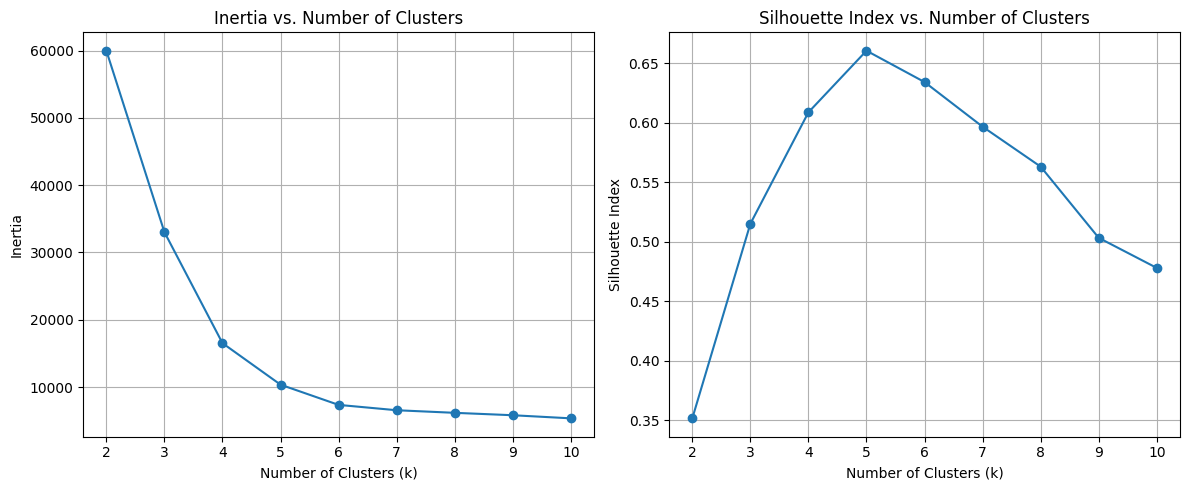

In [156]:
# Define the range of values ​​for k
k_values = range(2, 11)
inertias = []
silhouette_scores = []

# Calculate the inertia and silhouette index for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Print the inertias and silhouette indices for each k
for k, inertia, silhouette in zip(k_values, inertias, silhouette_scores):
    print(f'k = {k}, Inertia = {inertia}, Silhouette Index = {silhouette}')

# Plot inertia as a function of k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.xticks(k_values)
plt.grid(True)

# Plot the silhouette index as a function of k
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Index')
plt.title('Silhouette Index vs. Number of Clusters')
plt.xticks(k_values)
plt.grid(True)

# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

In [157]:
dump(model, open("../models/k_means_6_clusters_42.sav", "wb"))

The project required dividing the data into 6 groups, which was accomplished. After analyzing variations in the number of divisions to be performed and the possible inertia and silhouette index results for each, it was determined that 6 was an adequate number of groups to divide the data into, with 5 perhaps being the most optimal. Therefore, the analysis performed and the results obtained were satisfactory.

In [158]:
# Algorithm for classifying new data
def predict_cluster(features):
    features = [features[0], features[6], features[7]]
    features_scaled = scaler.transform([features])
    pred = model.predict(features_scaled)[0]
    return pred

In [159]:
res = predict_cluster([3.8462, 52.0, 6.281853, 1.081081, 565.0, 2.181467, 37.85, -122.25, 3.422])
print(f"Classification cluster: {res}")

Classification cluster: 1


Once the data has been divided and scaled correctly, and the cluster classification obtained, a supervised classification algorithm is trained.  
In this case, we will test the XGBoost boosting algorithm.

In [160]:
# Splitting data
y_train = X_train_scaled["cluster"]
X_train_scaled = X_train_scaled.drop("cluster", axis=1)

y_test = X_test_scaled["cluster"]
X_test_scaled = X_test_scaled.drop("cluster", axis=1)

In [161]:
# ML Models
model = XGBClassifier(random_state = 42, objective='multi:softprob', num_class=6, max_depth=3, n_estimators=50, learning_rate=0.25)
# Training
model.fit(X_train_scaled, y_train)
# Predict
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

Accuracy Test:  0.994235588972431
F1 score Test:  0.9942361379068506
Precision Test:  0.9942449949174255
Recall Test:  0.994235588972431
Accuracy Train:  0.9975560847223963
F1 score Train:  0.99755609915945
Precision Train:  0.9975563415214194
Recall Train:  0.9975560847223963


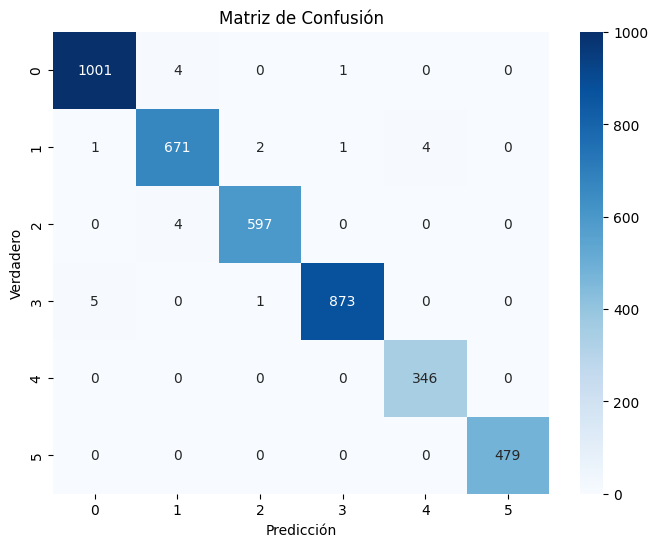

In [162]:
# Metrics
# Classification
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
f1_score_test = f1_score(y_test, y_pred_test, average='weighted')
f1_score_train = f1_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')

print("Accuracy Test: ", accuracy_test)
print("F1 score Test: ", f1_score_test)
print("Precision Test: ", precision_test)
print("Recall Test: ", recall_test)

print("Accuracy Train: ", accuracy_train)
print("F1 score Train: ", f1_score_train)
print("Precision Train: ", precision_train)
print("Recall Train: ", recall_train)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Graph the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [163]:
# Cross-validation: Checks whether good performance is maintained across multiple partitions of the dataset
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
print("F1 CV promedio:", scores.mean())

F1 CV promedio: 0.9914173534257017


In [164]:
dump(model, open("../models/xgb_classifier_optimized_42.sav", "wb"))


**Conclusions**

- An unsupervised classification model is implemented to divide the initial data into six clusters.
- The supervised classification model XGBClassifier is then evaluated, achieving over 99% accuracy and pecision.
- Despite the good metrics, it is recommended to work on a larger volume of data and see how the models behave, possibly leading us to having to fine-tune some parameters.